In [1]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
######################## ############ ################################
from tb_colormaps import *
plt.style.use('./bursa.mplstyle')

EPS = 10**-4

In [2]:

df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'donor',
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[df.vdj_sequence.notna()]

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

#read and parse ASC subtype lookup table
ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)
ASC_subtype_df.columns=['barcode','subtype','sample_uid_gex']
ASC_subtype_df = ASC_subtype_df[ASC_subtype_df.sample_uid_gex.str.startswith('TBd')]
ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid_gex']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()

#prepare merge column
df['cb_suid'] = df['cb'] + "_" + df['sample_uid_gex']

#copy ASC subtypes to main data frame
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']

# retain only single hq B cells 
df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)]
df_clean = df_clean[~(df_clean.celltype.str.startswith('Plasma'))]
naive =df_clean.Immune_All_Low_predicted_labels == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]


Index(['donor', 'tissue', 'vdj_sequence', 'count'], dtype='object')


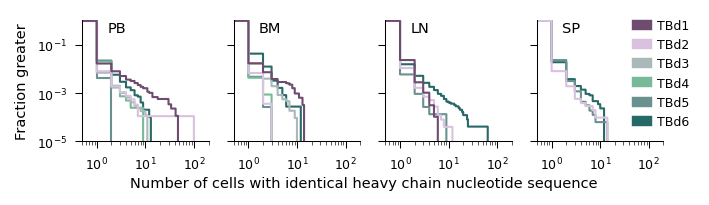

In [16]:
fig, ax = plt.subplots(1,4, figsize=(5,1.05), sharex=True, sharey=True)

cell_counts = df_clean.groupby(['donor', 'tissue','vdj_sequence']).size().reset_index()
cell_counts = cell_counts.rename(columns={0:'count'})

print(cell_counts.columns)
for it, tissue in enumerate(['PB', 'BM', 'LN', 'SP']):
    tissue_subset = cell_counts[cell_counts.tissue==tissue]
    sns.ecdfplot(data=tissue_subset, 
                 x='count', 
                 hue='donor', 
                 palette=donor_colors,
                 log_scale=(True,True), 
                 complementary=True, 
                 legend=False,
                 ax=ax[it])
    ax[it].set_xlabel('')
    ax[it].set_ylabel('')
    ax[it].set_xlim([0.5,200])
    ax[it].set_ylim([10**-5,1.1])
    ax[it].text(0.2, 0.9, tissue, transform = ax[it].transAxes)

fig.supxlabel('Number of cells with identical heavy chain nucleotide sequence', fontsize=7, y=-0.2)
ax[0].set_ylabel('Fraction greater')

for donor in donors:
    ax[-1].plot([],[],color=donor_colors[donor], label=donor, lw=5)


ax[-1].legend(loc='upper left', bbox_to_anchor=(0.7,1.1), frameon=False, handlelength=0.8)
sns.despine(fig)
fig.savefig(f'{FIGURE_OUTDIR}/EDFigure10/clonal_expansion_by_donor_and_tissue.pdf', bbox_inches='tight')

